## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_parquet('results/ER-norel/results.parquet')
df.shape

(1400, 28)

## Read the data

Get a dataframe for each experiment

In [4]:
dfs = {"er_1800": df}
for a, df in dfs.items():
    print(a, df.shape)

er_1800 (1400, 28)


## Set topology and timeout

In [5]:
for name, df in dfs.items():
    if name.startswith("ba"):
        df["Topology"] = "Barabasi-Albert"
    elif name.startswith("er"):
        df["Topology"] = "Erdos-Renyi"
    else:
        raise ValueError("Unknown topology")

In [6]:
for name, df in dfs.items():
    if name.endswith("480"):
        df["Timeout"] = 480
    elif name.endswith("900"):
        df["Timeout"] = 900
    elif name.endswith("1800"):
        df["Timeout"] = 1800
    else:
        raise ValueError("Unknown timeout")

Remove unused columns (w.r.t further analysis)

In [7]:
cols_to_get = ['Output', 'Inferences', 'Time', 'Seed', 'RepProb', 'Infr', 'Flows',
       'Nodes', 'Edges', 'Topology', 'Timeout', 'timestamp', 'time_this_iter_s', 'time_total_s']

for df in dfs.values():
    df.drop(columns=[col for col in df.columns if col not in cols_to_get], inplace=True)

Set the types of the columns

In [8]:
for df in dfs.values():
    df['Output'] = df['Output'].apply(lambda x: 'no_result' if x == "{}" else x)
    df['Output'] = df['Output'].apply(lambda x: 'success' if x not in ['no_result', 'timeout'] else x)
    df["Inferences"] = df["Inferences"].replace({"None": 0})

    df["Inferences"] = df["Inferences"].astype(np.int64)
    df["Time"] = df["Time"].astype(np.float64)
    df["Seed"] = df["Seed"].astype(np.int32)
    df["RepProb"] = df["RepProb"].astype(np.float64)
    df["Flows"] = df["Flows"].astype(np.int32)
    df["Nodes"] = df["Nodes"].astype(np.int16)
    df["Edges"] = df["Edges"].astype(np.int32)

Statistics on the number of _success_, _timeout_ and _no_result_ labels

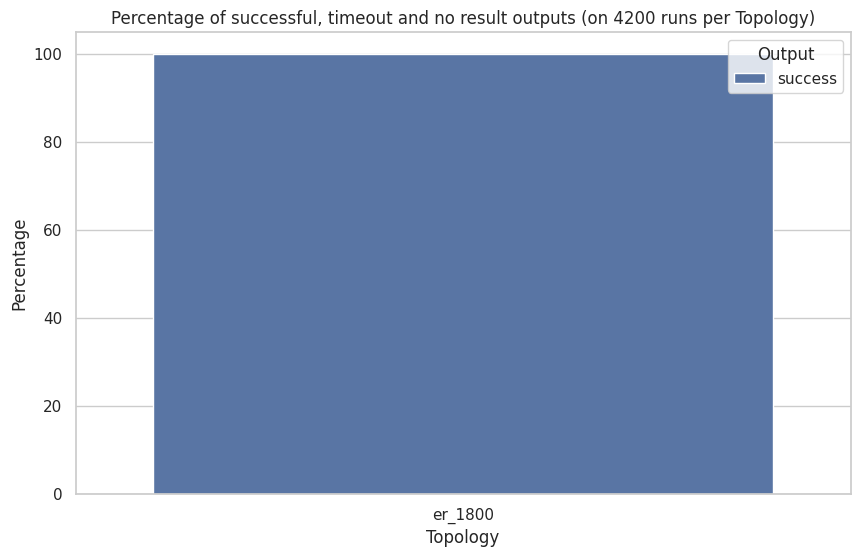

In [10]:
# plot the above statistics by adding them to a df
stats = []
for name, df in dfs.items():
    for output in df["Output"].unique():
        count = len(df[df["Output"] == output])
        stats.append({"Topology": name, "Output": output, "Count": (count / 1400) * 100})

df_stats = pd.DataFrame(stats)

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x="Topology", y="Count", hue="Output", data=df_stats)
plt.title("Percentage of successful, timeout and no result outputs (on 4200 runs per Topology)")
plt.ylabel("Percentage")
plt.show()


In [11]:
df_merged = pd.concat(dfs.values())

<Figure size 1000x600 with 0 Axes>

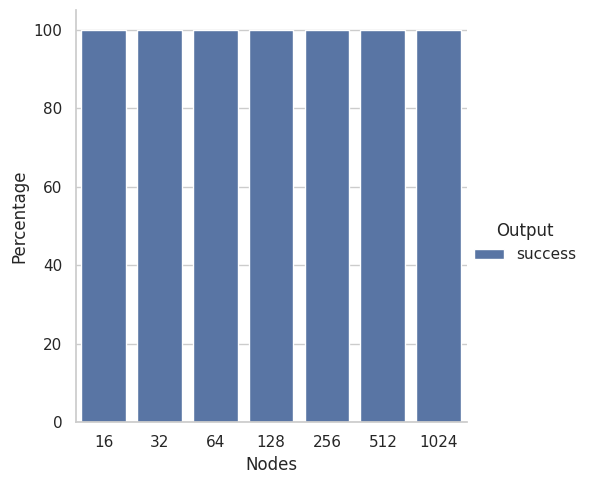

In [14]:
df_ttno = df_merged.copy().groupby(["Topology", "Nodes", "Output"]).size().reset_index(name="Count")
df_tot = df_merged.copy().groupby(["Topology", "Nodes"]).size().reset_index(name="Count")

df_ttno["Percentage"] = (df_ttno["Count"] / df_tot["Count"]) * 100

plt.figure(figsize=(10, 6))
sns.catplot(data=df_ttno, x="Nodes", y="Percentage", hue="Output", kind="bar", errorbar=None)
plt.savefig("plots/timeout_nodes.pdf", format="pdf", dpi=600)
plt.show()


<Figure size 1000x600 with 0 Axes>

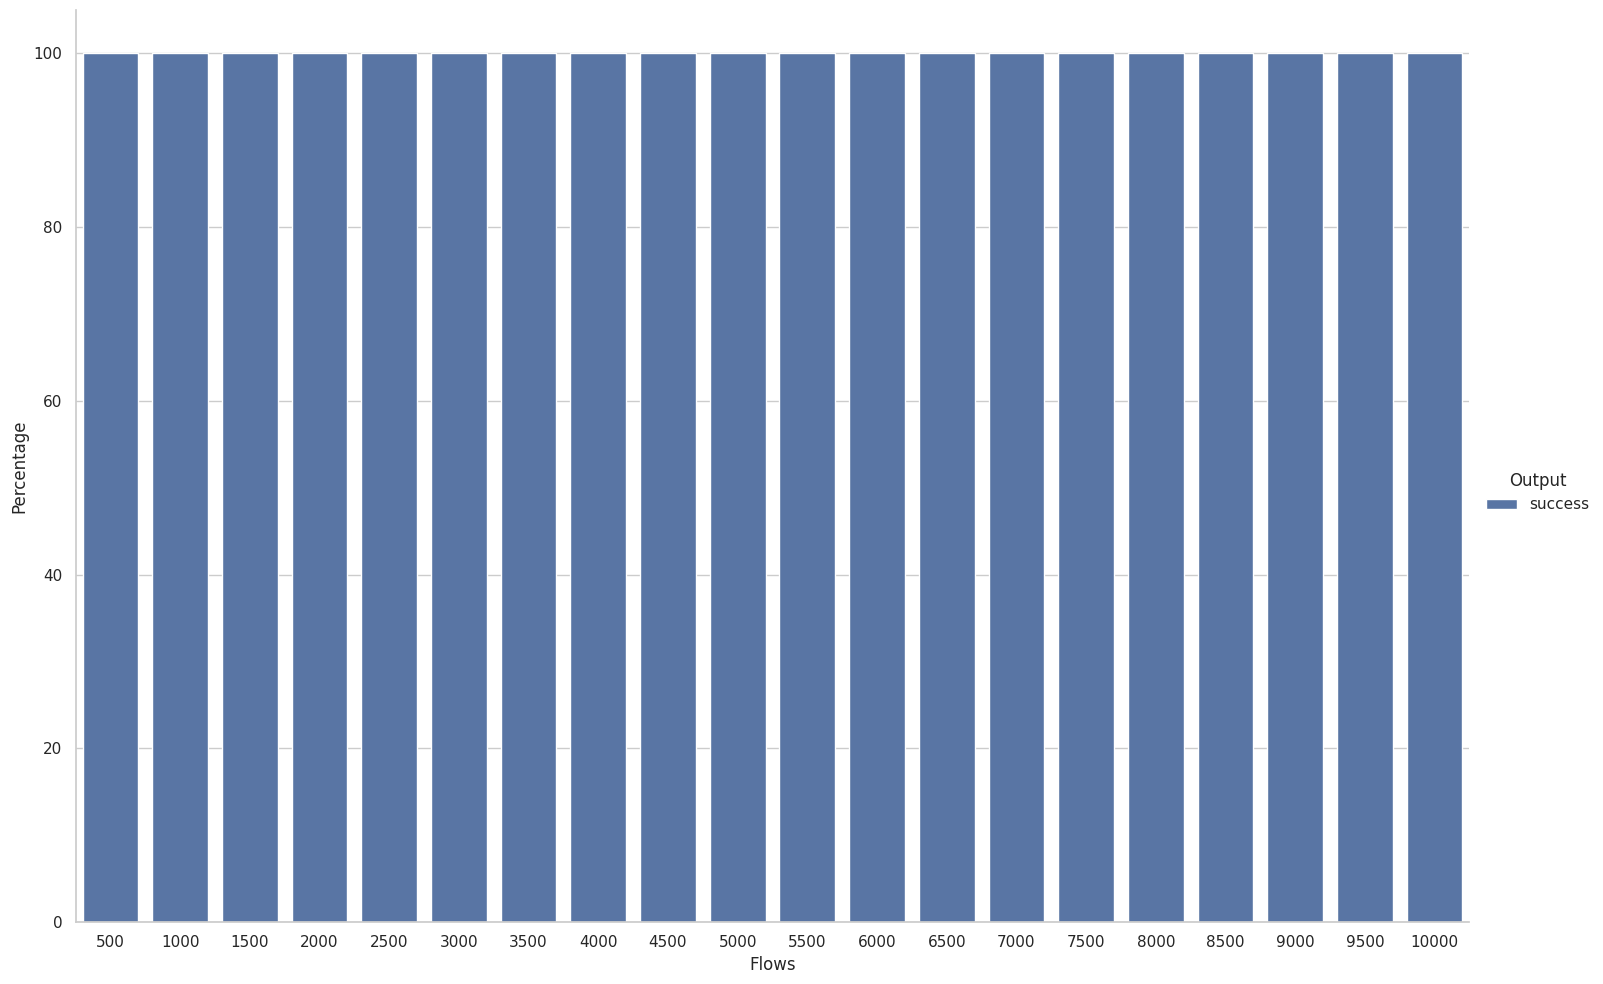

In [15]:
df_ttfo = df_merged.copy().groupby(["Topology", "Flows", "Output"]).size().reset_index(name="Count")
df_totf = df_merged.copy().groupby(["Topology", "Flows"]).size().reset_index(name="Count")

df_ttfo["Percentage"] = (df_ttfo["Count"] / df_totf["Count"]) * 100
plt.figure(figsize=(10, 6))
sns.catplot(data=df_ttfo, x="Flows", y="Percentage", hue="Output", kind="bar", aspect=1.5, height=10, errorbar=None)
plt.savefig("plots/timeout_flows.pdf", format="pdf", dpi=600)
plt.show()

In [19]:
df.to_parquet("results/clean/er-norel.parquet")